In [21]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from models.arima_forecasts import ARIMA_forecast, find_arima_spec
from models.random_walk import random_walk_forecast
from models.ann import ANN_forecast
from helper_functions import compute_rmse, load_monthly_baci_data, load_daily_baci_data, load_weekly_baci_data, load_daily_exog_data, load_weekly_exog_data, load_monthly_exog_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from models.ann import ANN_diff_forecast

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueWarning)

def ARIMA_vs_RW_vs_ANN(data, 
                       train_ratio=0.8, 
                       steps_ahead=1, 
                       n_forecasts=1, 
                       plot=False, 
                       res=15, 
                       arima_spec=(1, 1, 2), 
                       ann_spec=(2, 2), 
                       plot_all=True,
                       arima_f=True,
                       ann_f=True,
                       comb_f=True,
                       arimax_f=True,
                       annx_f=False,
                       exog=None,
                       benchmark=True):


    def plot_forecast(arima_fitted_df, 
                      arima_forecast_df, 
                      rw_forecast_df,
                      ann_fitted_df,
                      ann_forecast_df,
                      train_df,
                      test_df,
                      res=15):
        true_values = pd.concat([train, test])

        # Plot
        plt.figure(figsize=(15,7))

        plt.plot(true_values.index[-res - steps_ahead:], true_values[-res - steps_ahead:].values, color="blue", label='observed')
        plt.plot(arima_fitted_df.index[-res:], arima_fitted_df[-res:].values, color='green', label='ARIMA fitted')
        plt.plot(ann_fitted_df.index[-res:], ann_fitted_df[-res:].values, color='red', label='ANN fitted')
        
        
        # Rename columns of train_df.iloc[-1] to match rw_forecast_df's columns
        # Convert the last value of train_df to a dataframe with the same column name as rw_forecast_df
        renamed_row = pd.DataFrame([arima_fitted_df.values[-1]], columns=arima_forecast_df.columns, index=[arima_fitted_df.index[-1]])
        arima_forecast_df_merged = pd.concat([renamed_row, arima_forecast_df])
    
        renamed_row = pd.DataFrame([ann_fitted_df.values[-1]], columns=ann_forecast_df.columns, index=[ann_fitted_df.index[-1]])
        ann_forecast_df_merged = pd.concat([renamed_row, ann_forecast_df])
      
        renamed_row = pd.DataFrame([train_df.iloc[-1]], columns=rw_forecast_df.columns, index=[train_df.index[-1]])
        rw_forecast_df_merged = pd.concat([renamed_row, rw_forecast_df])


        plt.plot(arima_forecast_df_merged.index, arima_forecast_df_merged.values, color='green', label='ARIMA forecast', linestyle=":")
        plt.plot(rw_forecast_df_merged.index, rw_forecast_df_merged.values, color="purple", label="RW forecast", linestyle=":")
        plt.plot(ann_forecast_df_merged.index, ann_forecast_df_merged.values, color="red", label="ANN forecast", linestyle=":")

        plt.legend()
        plt.show()
        print(f"ARIMA MSE: {compute_rmse(test, arima_forecast_df)}")
        print(f"RW MSE: {compute_rmse(test, rw_forecast_df)}")
        print(f"ANN MSE: {compute_rmse(test, ann_forecast_df)}")




    train_size = int(train_ratio * len(data))
    arima_rmses, arimax_rmses, rw_rmses, ann_rmses, annx_rmses, comb_rmses = [], [], [], [], [], []
    
    # Initialize empty DataFrames with 'Date' as the index
    columns = ['Forecast']
    first_train_size = train_size
    arima_all_forecasts_df = arimax_all_forecasts_df = rw_all_forecasts_df = ann_all_forecasts_df = annx_all_forecasts_df = comb_all_forecasts_df = pd.DataFrame(columns=columns).set_index(pd.DatetimeIndex([], name='Date'))
    
    for _ in range(n_forecasts):
        print("Forecast number " + str(_ + 1))
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + steps_ahead]
        exog_train = exog.iloc[:train_size]
        exog_test = exog.iloc[train_size: train_size + steps_ahead]

        # Random Walk forecast
        rw_forecast_df = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast_df)
        rw_rmses.append(rw_rmse)
        rw_all_forecasts_df = pd.concat([rw_all_forecasts_df, rw_forecast_df])


        if arima_f:
            # ARIMA forecast
            arima_fitted_df, arima_forecast_df, arima_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=None)
            arima_rmse = compute_rmse(test, arima_forecast_df)
            arima_rmses.append(arima_rmse)
            arima_all_forecasts_df = pd.concat([arima_all_forecasts_df, arima_forecast_df])
        if arimax_f:
            # ARIMAX forecast
            arimax_fitted_df, arimax_forecast_df, arimax_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=exog)
            #print(arima_forecast_df.values)
            arimax_rmse = compute_rmse(test, arimax_forecast_df)
            arimax_rmses.append(arimax_rmse)
            arimax_all_forecasts_df = pd.concat([arimax_all_forecasts_df, arimax_forecast_df])


        if ann_f:
            # ANN forecast
            ann_fitted_df, ann_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1])
            ann_rmse = compute_rmse(test, ann_forecast_df)
            ann_rmses.append(ann_rmse)
            ann_all_forecasts_df = pd.concat([ann_all_forecasts_df, ann_forecast_df])
        
        if annx_f:
             # ANNX forecast
            annx_fitted_df, annx_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1],
                                                        exog_train=exog_train,
                                                        exog_test=exog_test)
            annx_rmse = compute_rmse(test, annx_forecast_df)
            annx_rmses.append(annx_rmse)
            annx_all_forecasts_df = pd.concat([annx_all_forecasts_df, annx_forecast_df])

        if comb_f:
            # Combination forecast
            comb_forecast_df = pd.DataFrame()
            comb_forecast_df["Forecast"] = (ann_forecast_df["Forecast"] + arima_forecast_df["Forecast"]) / 2
            comb_rmse = compute_rmse(test, comb_forecast_df)

            comb_rmses.append(comb_rmse)
            comb_all_forecasts_df = pd.concat([comb_all_forecasts_df, comb_forecast_df])

        train_size += steps_ahead

        if plot:
            plot_forecast(arima_fitted_df=arima_fitted_df,
                          arima_forecast_df=arima_forecast_df,
                          rw_forecast_df=rw_forecast_df,
                          ann_fitted_df=ann_fitted_df,
                          ann_forecast_df=ann_forecast_df,
                          train_df=train,
                          test_df=test,
                          res=res)
    if plot_all:
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(data.index[first_train_size:train_size + steps_ahead - 1], data[first_train_size:train_size + steps_ahead - 1].values, color="blue", label='observed')
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(rw_all_forecasts_df.index, rw_all_forecasts_df.values, color='purple', label='RW forecast', linestyle=":")

        if arima_f:
            plt.plot(arima_all_forecasts_df.index, arima_all_forecasts_df.values, color='green', label='ARIMA forecast', linestyle=":")
        if ann_f:
            plt.plot(ann_all_forecasts_df.index, ann_all_forecasts_df.values, color='red', label='ANN forecast', linestyle=":")
        if comb_f:
            plt.plot(comb_all_forecasts_df.index, comb_all_forecasts_df.values, color='black', label='ANN/ARIMA combination', linestyle=":")
        if arimax_f:
            plt.plot(arimax_all_forecasts_df.index, arimax_all_forecasts_df.values, color='brown', label='ARIMAX forecast', linestyle=":")
        if annx_f:
            plt.plot(annx_all_forecasts_df.index, annx_all_forecasts_df.values, color='pink', label='ANNX forecast', linestyle=":")


        # Rotate x-axis labels for better clarity
        plt.xticks(rotation=45)

        # Optional: Use fewer date ticks on the x-axis
        #import matplotlib.dates as mdates
        #plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Every week

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())  # Display unique labels only

        plt.tight_layout()  # Adjust the layout for better display
        plt.show()

        


    return arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses

In [22]:
data_freq = "daily"
exog_inc = True
if data_freq == "daily":
    df = load_daily_baci_data()
    if exog_inc:
        exog = load_daily_exog_data()
elif data_freq == "weekly":
    df = load_weekly_baci_data()
    if exog_inc:
        exog = load_weekly_exog_data()
else:
    df = load_monthly_baci_data()
    if exog_inc:
        exog = load_monthly_exog_data()
        


            IRON_CLOSE  COAL_CLOSE
Date                              
2013-10-18       985.0      1012.0
2013-10-21       980.0      1003.0
2013-10-22       967.0      1015.0
2013-10-23       956.0      1015.0
2013-10-24       938.0      1015.0
            CLOSE
Date             
2013-10-18   3264
2013-10-21   3200
2013-10-22   3110
2013-10-23   2943
2013-10-24   2775
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29103.382, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29881.406, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29109.394, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29232.123, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29879.406, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29105.314, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29107.815, Time=1.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29101.033, Time=1.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29102.03

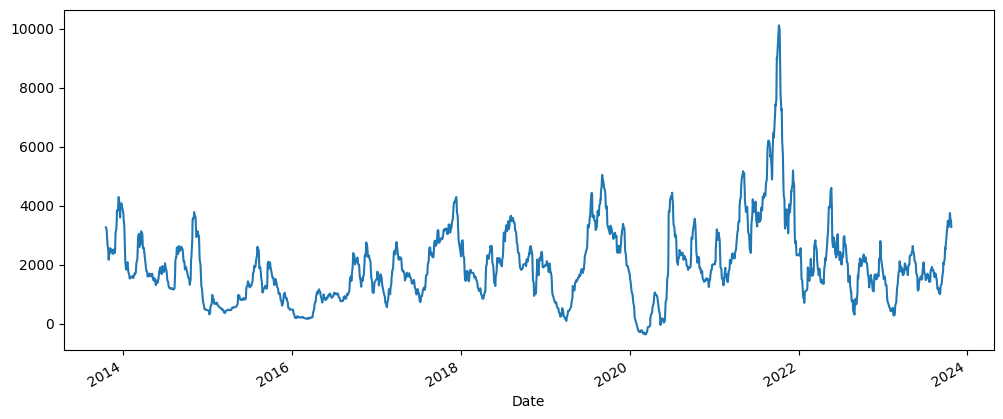

In [23]:

if exog_inc:
    # Inner join both dataframes on their index to ensure they have the same timestamp
    result = df.join(exog, how='inner', lsuffix='_baci', rsuffix='_ironfut')

    # Split the result back into individual dataframes if needed
    df = result[['CLOSE']]
    exog = result[['IRON_CLOSE', "COAL_CLOSE"]]

    # Rename the columns of the individual dataframes to 'CLOSE'
    df = df.rename(columns={'CLOSE_baci': 'CLOSE'})


#find_arima_spec(df)
print(exog.head())
print(df.head())
find_arima_spec(df)


In [25]:
train_ratio = 0.9
n_forecasts = 50
steps_ahead = 1
res = 200
arima_spec = (3, 1, 3)
ann_spec = (2, 2)
plot = False
plot_all = True
res = 50
exog = exog
arima_f, arimax_f, ann_f, annx_f, comb_f = True, True, True, True, False
arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses = ARIMA_vs_RW_vs_ANN(data=df, 
                                                                  res=res, 
                                                                  train_ratio=train_ratio,
                                                                  n_forecasts=n_forecasts,
                                                                  steps_ahead=steps_ahead,
                                                                  plot=False,
                                                                  arima_spec=arima_spec,
                                                                  ann_spec=ann_spec,
                                                                  exog=exog,
                                                                  arima_f=arima_f,
                                                                  arimax_f = arimax_f,
                                                                  ann_f=ann_f,
                                                                  annx_f=annx_f,
                                                                  comb_f=comb_f)
print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}")
print(f"ARIMAX RMSEs: {'N/A' if not arima_rmses else np.average(arimax_rmses)}")
print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}")
print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}")
print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}")
print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}")


# Open the file in write mode
with open('log.txt', 'a') as file:
    print("Monthly Forecast: Train ratio: " + str(train_ratio) + ". " + str(steps_ahead) + " step ahead. " + str(n_forecasts) + " forecasts", file=file)
    print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}", file=file)
    print(f"ARIMAX RMSEs: {'N/A' if not arimax_rmses else np.average(arimax_rmses)}", file=file)
    print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}", file=file)
    print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}", file=file)
    print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}", file=file)
    print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}", file=file)



Forecast number 1
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 2111
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -13059.524
Date:                Wed, 01 Nov 2023   AIC                          26133.047
Time:                        20:10:01   BIC                          26172.628
Sample:                             0   HQIC                         26147.541
                               - 2111                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1591      0.064     33.895      0.000       2.034       2.284
ar.L2         -1.5699      0.094    -16.728      0.000      -1.754      -1.386
ar.L3          0.3550      0.039  

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2111/2111 [==============================] - 2s 747us/step - loss: 1.3732
Epoch 2/10
2111/2111 [==============================] - 1s 684us/step - loss: 1.2239
Epoch 3/10
2111/2111 [==============================] - 1s 681us/step - loss: 1.1565
Epoch 4/10
2111/2111 [==============================] - 1s 685us/step - loss: 1.1103
Epoch 5/10
2111/2111 [==============================] - 1s 689us/step - loss: 1.0808
Epoch 6/10
2111/2111 [==============================] - 1s 686us/step - loss: 1.0617
Epoch 7/10
2111/2111 [==============================] - 1s 684us/step - loss: 1.0538
Epoch 8/10
2111/2111 [==============================] - 1s 674us/step - loss: 1.0464
Epoch 9/10
2111/2111 [==============================] - 1s 672us/step - loss: 1.0412
Epoch 10/10
1/1 [==============================] - 0s 22ms/step
Epoch 1/10
2111/2111 [==============================] - 2s 713us/step - loss: 1.5855
Epoch 2/10
2111/2111 [==============================] - 1s 700us/step - loss: 1.4904
Epoch 3/10
2

C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 2115
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -13082.477
Date:                Wed, 01 Nov 2023   AIC                          26178.954
Time:                        20:12:16   BIC                          26218.548
Sample:                             0   HQIC                         26193.451
                               - 2115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1574      0.064     33.656      0.000       2.032       2.283
ar.L2         -1.5675      0.094    -16.671      0.000      -1.752      -1.383
ar.L3          0.3544      0.039      9.044      0.0